# RB Evaluation Analysis

This notebook demonstrates how to load and analyze Inspect AI evaluation logs.

In [18]:
import sys
import os
from pathlib import Path

import pandas as pd
import numpy as np

src_path = Path.cwd() / "src"
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

from dataset.dataloader import Dataloader
from experiments.utils.analysis import (
    load_eval_logs_to_dataframe,
    aggregate_runs,
    get_model_summary_stats,
    get_per_paper_stats,
    get_global_coverage_stats
)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)

print(f"Working from: {Path.cwd()}")

Working from: /Users/christineye/rb-release


## 1. Configure Paths

Update these paths to point to your evaluation logs and data directories.

In [35]:
import glob as glob_module

base_dir = Path.cwd()

# Define patterns to search for
log_type = "base"
log_patterns = [
    "logs/gemini-25-{}*".format(log_type),
    # "logs/gemini-3-base-*",
    "logs/claude-37-{}*".format(log_type),
    "logs/claude-4-{}*".format(log_type),
    "logs/o3-{}*".format(log_type),
    "logs/o4-mini-{}*".format(log_type),
    "logs/claude-45-{}*".format(log_type),
    "logs/gpt5-{}*".format(log_type),
]

# Find all directories matching the patterns
log_dirs = []
for pattern in log_patterns:
    matching = glob_module.glob(str(base_dir / pattern))
    log_dirs.extend(matching)

# Filter to only keep directories ending in -4, -5, or -6
# log_dirs = [d for d in log_dirs if d.endswith(('-4', '-5', '-6'))]

# Convert to absolute paths and filter existing
existing_dirs = [str(Path(d).resolve()) for d in log_dirs if Path(d).exists()]

print(f"Found {len(existing_dirs)} log directories")
for d in existing_dirs:
    print(f"  - {d}")

Found 42 log directories
  - /Users/christineye/rb-release/logs/gemini-25-base-1
  - /Users/christineye/rb-release/logs/gemini-25-base-6
  - /Users/christineye/rb-release/logs/gemini-25-base-5
  - /Users/christineye/rb-release/logs/gemini-25-base-2
  - /Users/christineye/rb-release/logs/gemini-25-base-3
  - /Users/christineye/rb-release/logs/gemini-25-base-4
  - /Users/christineye/rb-release/logs/claude-37-base-6
  - /Users/christineye/rb-release/logs/claude-37-base-1
  - /Users/christineye/rb-release/logs/claude-37-base-2
  - /Users/christineye/rb-release/logs/claude-37-base-5
  - /Users/christineye/rb-release/logs/claude-37-base-4
  - /Users/christineye/rb-release/logs/claude-37-base-3
  - /Users/christineye/rb-release/logs/claude-4-base-6
  - /Users/christineye/rb-release/logs/claude-4-base-1
  - /Users/christineye/rb-release/logs/claude-4-base-2
  - /Users/christineye/rb-release/logs/claude-4-base-5
  - /Users/christineye/rb-release/logs/claude-4-base-4
  - /Users/christineye/rb-re

## 2. Load Dataloader

Load papers and tasks for computing difficulty-weighted scores.

In [37]:
dataloader = Dataloader(
    task_types=["numeric"],
    load_text=False,
    filters={"source": "expert"}
)

print(f"Loaded {len(dataloader.papers)} papers")
print(f"Total tasks: {sum(len(p.tasks) for p in dataloader.papers.values())}")

Loaded 20 papers
Total tasks: 111


## 3. Load Evaluation Logs

Load all evaluation logs into a structured DataFrame.

In [38]:
if not existing_dirs:
    print("WARNING: No log directories found. Creating empty DataFrame.")
    df = pd.DataFrame()
else:
    df = load_eval_logs_to_dataframe(existing_dirs, dataloader)
    print(f"\nLoaded {len(df)} rows")
    print(f"Models: {df.index.get_level_values('model').unique().tolist()}")
    print(f"Papers: {len(df.index.get_level_values('paper').unique())} unique papers")
    print(f"\nDataFrame structure:")
    print(df.head())

⚠️  Multiple evals found for Gemini 2.5 run 5 paper tng_hod: 2 files. Taking most recent: 2025-11-21T11-40-00-08-00_tng-hod_MEfkoWxtHEUMLqYNjXpdip.eval


⚠️  Multiple evals found for Gemini 2.5 run 5 paper tng_hod: 2 files. Taking most recent: 2025-11-21T11-40-00-08-00_tng-hod_MEfkoWxtHEUMLqYNjXpdip.eval

Loaded 5502 rows
Models: ['GPT-5', 'Gemini 2.5', 'Sonnet 3.7', 'Sonnet 4', 'Sonnet 4.5', 'o3', 'o4-mini']
Papers: 20 unique papers

DataFrame structure:
                                                                         accuracy  \
model run paper         task                                                        
GPT-5 1   MUSE_outflows _summary                                              0.0   
                        dust_reddening                                        NaN   
                        electron_density                                      NaN   
                        narrow_and_broad_line_decomposition_for_J080427       NaN   
                        outflow_energetics                                    NaN   

                                                                         difficulty_weighted_accur

## 3.5. Global Task Coverage

How many tasks have been solved by at least one model across all runs?

In [39]:
# Global task coverage statistics
if not df.empty:
    coverage = get_global_coverage_stats(df)
    print("\n=== GLOBAL TASK COVERAGE ===")
    print(f"Total unique tasks: {coverage['total_tasks']}")
    print(f"Tasks solved by at least one model/run: {coverage['solved_tasks']}")
    print(f"Coverage: {coverage['solved_percentage']:.1f}%")
    print(f"Unsolved tasks: {coverage['total_tasks'] - coverage['solved_tasks']}")
else:
    print("No data available")


=== GLOBAL TASK COVERAGE ===
Total unique tasks: 111
Tasks solved by at least one model/run: 67
Coverage: 60.4%
Unsolved tasks: 44


## 4. Model Summary Statistics

Overall performance across all papers and runs.

In [40]:
if not df.empty:
    model_stats = get_model_summary_stats(df)
    print("\n=== MODEL SUMMARY STATISTICS ===")
    display(model_stats.round(3))
else:
    print("No data available")


=== MODEL SUMMARY STATISTICS ===


,Avg Accuracy,Bootstrap Accuracy,Std Accuracy,Best Accuracy,Avg Difficulty-Weighted,Best Difficulty-Weighted,Avg Response Rate,Avg Output Tokens,Avg Reasoning Tokens,Avg Runtime (min),Avg LLM Time (min),Avg Tool Time (min)
Model,,,,,,,,,,,,
GPT-5,0.183,0.183,0.021,0.280,0.149,0.244,0.865,25215.400,15048.533,61.409,8.686,47.017
Gemini 2.5,0.155,0.154,0.027,0.332,0.116,0.289,0.687,27539.083,6310.683,127.795,7.325,97.044
Sonnet 3.7,0.187,0.187,0.026,0.333,0.167,0.329,0.927,33397.233,0.000,127.479,8.764,83.750
Sonnet 4,0.194,0.195,0.031,0.364,0.166,0.349,0.890,28974.883,0.000,100.529,8.524,82.628
Sonnet 4.5,0.223,0.223,0.034,0.387,0.186,0.354,0.881,31022.100,0.000,105.887,10.409,90.724
o3,0.161,0.161,0.029,0.307,0.132,0.270,0.762,17521.167,10618.133,20.320,4.288,13.810
o4-mini,0.145,0.145,0.019,0.224,0.122,0.176,0.610,14182.525,11067.200,6.225,2.784,2.269


## 5. Per-Paper Statistics

Performance breakdown by paper across all models and runs.

In [41]:
if not df.empty:
    paper_stats = get_per_paper_stats(df)
    print("\n=== PER-PAPER STATISTICS ===")
    display(paper_stats.round(3))
else:
    print("No data available")


=== PER-PAPER STATISTICS ===


,Avg Accuracy,Std Accuracy,Best Accuracy,Avg Difficulty-Weighted,Avg Response Rate,Num Evaluations
MUSE_outflows,0.048,0.097,0.400,0.041,0.914,42.0
abacus,0.000,0.000,0.000,0.000,0.225,42.0
astm3,0.065,0.115,0.429,0.073,0.571,42.0
bayes_cal,0.444,0.220,0.667,0.326,0.885,42.0
chandra_representation,0.262,0.214,0.750,0.226,0.548,42.0
disk_ridges,0.029,0.071,0.200,0.036,0.924,42.0
eht_resolve,0.030,0.082,0.250,0.028,0.935,42.0
fable_mps,0.134,0.115,0.500,0.127,0.589,42.0
galaxy_manifold,0.083,0.088,0.300,0.086,0.931,42.0
galaxy_soptics,0.196,0.092,0.375,0.097,1.000,42.0


## 6. Accuracy by Model and Paper

Average accuracy for each model on each paper (aggregated across runs).

In [17]:
if not df.empty:
    accuracy_table = aggregate_runs(df, "accuracy", "mean")
    print("\n=== ACCURACY BY MODEL AND PAPER (Mean across runs) ===")
    display(accuracy_table.round(3))
else:
    print("No data available")


=== ACCURACY BY MODEL AND PAPER (Mean across runs) ===


paper,MUSE_outflows,abacus,astm3,bayes_cal,disk_ridges,eht_resolve,galaxy_manifold,galaxy_soptics,gw_cosmo,gw_nsbh,hubble_trails,lensing_dr6_growth,ls_cal,mars_clouds,phangs_PAHs,tng_hod,trgb_std_candle,ver_waves
model,,,,,,,,,,,,,,,,,,
GPT-5,0.133,0.0,0.000,0.389,0.000,0.000,0.100,0.125,0.500,0.074,0.571,0.000,0.533,0.000,0.000,0.167,0.0,0.417
Gemini 2.5,0.000,0.0,0.000,0.222,0.000,0.083,0.067,0.167,0.083,0.185,0.190,0.000,0.467,0.000,0.067,0.125,0.0,0.333
Sonnet 3.7,0.000,0.0,0.000,0.556,0.200,0.083,0.100,0.250,0.083,0.222,0.619,0.167,0.400,0.333,0.000,0.125,0.0,0.333
Sonnet 4,0.200,0.0,0.095,0.556,0.133,0.083,0.000,0.125,0.083,0.148,0.524,0.000,0.267,0.000,0.067,0.208,0.0,0.250
Sonnet 4.5,0.067,0.0,0.095,0.611,0.200,0.167,0.000,0.188,0.000,0.167,0.667,0.000,0.467,0.500,0.067,0.292,0.0,0.250
o3,0.133,0.0,0.000,0.278,0.000,0.000,0.133,0.208,0.000,0.111,0.524,0.000,0.333,0.500,0.067,0.167,0.0,0.250
o4-mini,0.067,0.0,0.000,0.000,0.067,0.000,0.033,0.167,0.167,0.111,0.333,0.000,0.467,0.500,0.000,0.167,0.0,0.250


## 7. Difficulty-Weighted Accuracy

Difficulty-weighted scores accounting for task complexity.

In [18]:
if not df.empty:
    difficulty_weighted_table = aggregate_runs(df, "difficulty_weighted_accuracy", "mean")
    print("\n=== DIFFICULTY-WEIGHTED ACCURACY BY MODEL AND PAPER ===")
    display(difficulty_weighted_table.round(3))
else:
    print("No data available")


=== DIFFICULTY-WEIGHTED ACCURACY BY MODEL AND PAPER ===


paper,MUSE_outflows,abacus,astm3,bayes_cal,disk_ridges,eht_resolve,galaxy_manifold,galaxy_soptics,gw_cosmo,gw_nsbh,hubble_trails,lensing_dr6_growth,ls_cal,mars_clouds,phangs_PAHs,tng_hod,trgb_std_candle,ver_waves
model,,,,,,,,,,,,,,,,,,
GPT-5,0.121,0.0,0.000,0.222,0.000,0.000,0.094,0.038,0.435,0.020,0.536,0.000,0.432,0.000,0.00,0.160,0.0,0.231
Gemini 2.5,0.000,0.0,0.000,0.194,0.000,0.079,0.062,0.077,0.058,0.127,0.167,0.000,0.420,0.000,0.03,0.120,0.0,0.154
Sonnet 3.7,0.000,0.0,0.000,0.444,0.250,0.079,0.125,0.115,0.101,0.147,0.619,0.212,0.346,0.333,0.00,0.120,0.0,0.205
Sonnet 4,0.182,0.0,0.088,0.444,0.167,0.079,0.000,0.038,0.101,0.088,0.488,0.000,0.272,0.000,0.03,0.227,0.0,0.077
Sonnet 4.5,0.061,0.0,0.114,0.481,0.250,0.159,0.000,0.077,0.000,0.074,0.643,0.000,0.420,0.556,0.03,0.227,0.0,0.077
o3,0.121,0.0,0.000,0.167,0.000,0.000,0.135,0.103,0.000,0.029,0.488,0.000,0.284,0.667,0.03,0.160,0.0,0.128
o4-mini,0.061,0.0,0.000,0.000,0.083,0.000,0.031,0.090,0.145,0.029,0.310,0.000,0.420,0.667,0.00,0.160,0.0,0.128


## 8. Best Run Performance

Best accuracy achieved by each model on each paper (max across runs).

In [19]:
if not df.empty:
    best_accuracy_table = aggregate_runs(df, "accuracy", "max")
    print("\n=== BEST ACCURACY BY MODEL AND PAPER (Max across runs) ===")
    display(best_accuracy_table.round(3))
else:
    print("No data available")


=== BEST ACCURACY BY MODEL AND PAPER (Max across runs) ===


paper,MUSE_outflows,abacus,astm3,bayes_cal,disk_ridges,eht_resolve,galaxy_manifold,galaxy_soptics,gw_cosmo,gw_nsbh,hubble_trails,lensing_dr6_growth,ls_cal,mars_clouds,phangs_PAHs,tng_hod,trgb_std_candle,ver_waves
model,,,,,,,,,,,,,,,,,,
GPT-5,0.2,0.0,0.000,0.500,0.0,0.00,0.1,0.125,0.50,0.111,0.571,0.0,0.6,0.0,0.0,0.250,0.0,0.50
Gemini 2.5,0.0,0.0,0.000,0.500,0.0,0.25,0.2,0.250,0.25,0.333,0.429,0.0,0.6,0.0,0.2,0.375,0.0,0.50
Sonnet 3.7,0.0,0.0,0.000,0.667,0.2,0.25,0.2,0.250,0.25,0.222,0.714,0.5,0.4,1.0,0.0,0.250,0.0,0.50
Sonnet 4,0.2,0.0,0.143,0.667,0.2,0.25,0.0,0.125,0.25,0.222,0.571,0.0,0.4,0.0,0.2,0.375,0.0,0.25
Sonnet 4.5,0.2,0.0,0.143,0.833,0.2,0.25,0.0,0.250,0.00,0.222,0.714,0.0,0.6,1.0,0.2,0.375,0.0,0.25
o3,0.2,0.0,0.000,0.500,0.0,0.00,0.2,0.250,0.00,0.111,0.714,0.0,0.6,0.5,0.2,0.250,0.0,0.25
o4-mini,0.2,0.0,0.000,0.000,0.2,0.00,0.1,0.250,0.50,0.111,0.429,0.0,0.6,0.5,0.0,0.250,0.0,0.50


## 9. Token Usage and Timing Statistics

Token usage and timing breakdown by model.

In [9]:
if not df.empty:
    summary_df = df[df.index.get_level_values("task") == "_summary"].copy()
    
    token_stats = summary_df.groupby("model").agg({
        "input_tokens": "median",
        "output_tokens": "median",
        "reasoning_tokens": "median",
        "llm_time_minutes": "median",
        "tool_time_minutes": "median"
    })
    
    # Round to 2 significant figures
    for col in token_stats.columns:
        token_stats[col] = token_stats[col].apply(lambda x: float(f'{x:.2g}') if pd.notna(x) else x)
    
    print("\n=== TOKEN USAGE AND TIMING BY MODEL ===")
    display(token_stats)
else:
    print("No data available")


=== TOKEN USAGE AND TIMING BY MODEL ===


,input_tokens,output_tokens,reasoning_tokens,llm_time_minutes,tool_time_minutes
model,,,,,
GPT-5,810000.0,24000.0,14000.0,8.7,9.10
Gemini 2.5,2200000.0,24000.0,5500.0,7.4,9.20
Sonnet 3.7,66.0,32000.0,0.0,8.5,29.00
Sonnet 4,96.0,29000.0,0.0,8.5,23.00
Sonnet 4.5,95.0,30000.0,0.0,10.0,29.00
o3,710000.0,15000.0,8900.0,3.9,1.30
o4-mini,250000.0,10000.0,7700.0,2.1,0.39


## 10. Task-Level Analysis

Performance on individual tasks across all models.

In [ ]:
if not df.empty:
    task_df = df[df.index.get_level_values("task") != "_summary"].copy()
    
    if not task_df.empty:
        task_stats = task_df.groupby(["paper", "task"]).agg({
            "task_score": ["mean", "std", "count"],
            "task_difficulty": "first"
        }).round(3)
        
        print("\n=== TASK-LEVEL STATISTICS (First 20 tasks) ===")
        display(task_stats.head(20))
    else:
        print("No task-level data available")
else:
    print("No data available")

## 11. Export Tables

Save tables to CSV files for further analysis.

In [ ]:
if not df.empty:
    output_dir = Path("table_outputs")
    output_dir.mkdir(exist_ok=True)
    
    model_stats.to_csv(output_dir / "model_summary.csv")
    paper_stats.to_csv(output_dir / "paper_summary.csv")
    accuracy_table.to_csv(output_dir / "accuracy_by_model_paper.csv")
    difficulty_weighted_table.to_csv(output_dir / "difficulty_weighted_accuracy.csv")
    
    print(f"\nTables exported to {output_dir}/")
    print("  - model_summary.csv")
    print("  - paper_summary.csv")
    print("  - accuracy_by_model_paper.csv")
    print("  - difficulty_weighted_accuracy.csv")
else:
    print("No data to export")

## 12. LaTeX Tables for Paper

Generate publication-ready LaTeX tables.

In [43]:
if not df.empty:
    summary_df = df[df.index.get_level_values("task") == "_summary"].copy()
    
    # Prepare data for LaTeX tables
    latex_data = []
    
    for model in sorted(summary_df.index.get_level_values("model").unique()):
        model_data = summary_df.xs(model, level="model")
        
        # Accuracy metrics (best per paper, then average)
        best_per_paper = model_data.groupby('paper')['accuracy'].max()
        avg_per_paper = model_data.groupby('paper')['accuracy'].mean()
        best_accuracy = best_per_paper.mean()
        avg_accuracy = avg_per_paper.mean()
        
        # Bootstrap std for accuracy: sample one run per paper
        rng = np.random.RandomState(42)
        n_bootstrap = 10000
        papers = model_data.index.get_level_values('paper').unique()
        
        # Pre-extract accuracy values for each paper
        paper_accuracies = []
        for paper in papers:
            paper_runs = model_data.xs(paper, level='paper')['accuracy'].values
            paper_accuracies.append(paper_runs)
        
        # Bootstrap accuracy
        bootstrap_accuracy_means = np.zeros(n_bootstrap)
        for i in range(n_bootstrap):
            bootstrap_sample = [rng.choice(runs) for runs in paper_accuracies]
            bootstrap_accuracy_means[i] = np.mean(bootstrap_sample)
        std_accuracy = np.std(bootstrap_accuracy_means)
        
        # Difficulty-weighted
        avg_dw_per_paper = model_data.groupby('paper')['difficulty_weighted_accuracy'].mean()
        avg_dw = avg_dw_per_paper.mean()
        
        # Response rate with bootstrap std: sample one run per paper
        avg_response_rate = model_data['response_rate'].mean()
        
        # Pre-extract response rate values for each paper
        paper_response_rates = []
        for paper in papers:
            paper_runs = model_data.xs(paper, level='paper')['response_rate'].values
            paper_response_rates.append(paper_runs)
        
        # Bootstrap response rate
        bootstrap_response_means = np.zeros(n_bootstrap)
        for i in range(n_bootstrap):
            bootstrap_sample = [rng.choice(runs) for runs in paper_response_rates]
            bootstrap_response_means[i] = np.mean(bootstrap_sample)
        std_response_rate = np.std(bootstrap_response_means)
        
        # Median tokens and timing
        median_output_tokens = model_data['output_tokens'].median()
        median_runtime = model_data['llm_time_minutes'].median() + model_data['tool_time_minutes'].median()
        
        latex_data.append({
            'Model': model,
            'Avg Accuracy': avg_accuracy,
            'Std Accuracy': std_accuracy,
            'Best Accuracy': best_accuracy,
            'Avg Difficulty-Weighted': avg_dw,
            'Avg Response Rate': avg_response_rate,
            'Std Response Rate': std_response_rate,
            'Median Output Tokens (K)': median_output_tokens / 1000,
            'Median Runtime': median_runtime,
        })
    
    latex_df = pd.DataFrame(latex_data)
    
    # Generate Table 1: Accuracy metrics with best-of-N
    print("\\begin{table}")
    print("\\centering")
    print("\\begin{tabular}{lcccc}")
    print("\\toprule")
    print("\\textbf{Model} & \\textbf{Unweighted score} & (standard dev.) & \\textbf{Best-of-N} & \\textbf{Difficulty-weighted score} \\\\")
    print("\\midrule")
    
    for _, row in latex_df.iterrows():
        print(f"{row['Model']} & {row['Avg Accuracy']:.2f} & {row['Std Accuracy']:.2f} & {row['Best Accuracy']:.2f} & {row['Avg Difficulty-Weighted']:.2f} \\\\")
    
    print("\\bottomrule")
    print("\\end{tabular}")
    print("\\caption{Average-of-6 scores on ReplicationBench with simple agent scaffold.}")
    print("\\label{tab:model_accuracy}")
    print()
    print("\\vspace{1em}")
    print()
    
    # Generate Table 2: Response rate and resource usage
    print("\\begin{tabular}{lcccc}")
    print("\\toprule")
    print("\\textbf{Model} & \\textbf{Tasks completed} & (standard dev.) & \\textbf{Median tokens (K)} & \\textbf{Median runtime (min)} \\\\")
    print("\\midrule")
    
    for _, row in latex_df.iterrows():
        tokens_k = int(round(row['Median Output Tokens (K)']))
        runtime_min = int(round(row['Median Runtime']))
        print(f"{row['Model']} & {row['Avg Response Rate']:.2f} & {row['Std Response Rate']:.2f} & {tokens_k} & {runtime_min} \\\\")
    
    print("\\bottomrule")
    print("\\end{tabular}")
    print("\\caption{Average-of-6 scores on ReplicationBench with simple agent scaffold.}")
    print("\\label{tab:model_performance}")
    print("\\end{table}")
else:
    print("No data available")

\begin{table}
\centering
\begin{tabular}{lcccc}
\toprule
\textbf{Model} & \textbf{Unweighted score} & (standard dev.) & \textbf{Best-of-N} & \textbf{Difficulty-weighted score} \\
\midrule
GPT-5 & 0.18 & 0.02 & 0.28 & 0.15 \\
Gemini 2.5 & 0.15 & 0.03 & 0.33 & 0.12 \\
Sonnet 3.7 & 0.19 & 0.03 & 0.33 & 0.17 \\
Sonnet 4 & 0.19 & 0.03 & 0.36 & 0.17 \\
Sonnet 4.5 & 0.22 & 0.03 & 0.39 & 0.19 \\
o3 & 0.16 & 0.03 & 0.31 & 0.13 \\
o4-mini & 0.14 & 0.02 & 0.22 & 0.12 \\
\bottomrule
\end{tabular}
\caption{Average-of-6 scores on ReplicationBench with simple agent scaffold.}
\label{tab:model_accuracy}

\vspace{1em}

\begin{tabular}{lcccc}
\toprule
\textbf{Model} & \textbf{Tasks completed} & (standard dev.) & \textbf{Median tokens (K)} & \textbf{Median runtime (min)} \\
\midrule
GPT-5 & 0.87 & 0.04 & 24 & 18 \\
Gemini 2.5 & 0.69 & 0.04 & 24 & 18 \\
Sonnet 3.7 & 0.93 & 0.05 & 32 & 37 \\
Sonnet 4 & 0.89 & 0.05 & 29 & 31 \\
Sonnet 4.5 & 0.88 & 0.04 & 30 & 40 \\
o3 & 0.76 & 0.04 & 15 & 5 \\
o4-mini & 0.6

## 13. Difficulty vs Success Rate Plot

Plot success rates binned by task difficulty, with bootstrap confidence intervals.


Success rates by difficulty (with bootstrap standard errors):

GPT-5:
  easiest (1-3): 23.91% ± 2.58%
   (4-6): 20.59% ± 2.32%
  hardest (7-9): 1.28% ± 1.26%

Gemini 2.5:
  easiest (1-3): 20.29% ± 2.40%
   (4-6): 16.67% ± 2.12%
  hardest (7-9): 1.28% ± 1.27%

Sonnet 3.7:
  easiest (1-3): 21.38% ± 2.47%
   (4-6): 21.90% ± 2.39%
  hardest (7-9): 8.97% ± 3.24%

Sonnet 4:
  easiest (1-3): 21.38% ± 2.47%
   (4-6): 22.55% ± 2.39%
  hardest (7-9): 6.41% ± 2.74%

Sonnet 4.5:
  easiest (1-3): 25.36% ± 2.59%
   (4-6): 25.16% ± 2.47%
  hardest (7-9): 5.13% ± 2.49%

o3:
  easiest (1-3): 20.29% ± 2.42%
   (4-6): 15.03% ± 2.05%
  hardest (7-9): 2.56% ± 1.79%

o4-mini:
  easiest (1-3): 19.20% ± 2.36%
   (4-6): 12.09% ± 1.89%
  hardest (7-9): 0.00% ± 0.00%

Task counts per difficulty bin:
  easiest (1-3): 276 tasks
   (4-6): 306 tasks
  hardest (7-9): 78 tasks


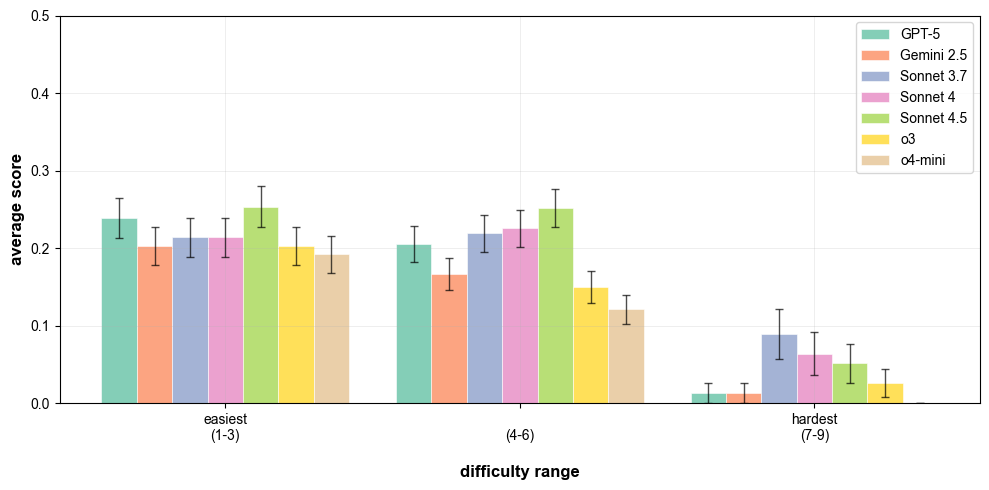

In [46]:
import matplotlib.pyplot as plt

if not df.empty:
    # Define difficulty bins
    BIN_RANGES = {
        'easiest\n(1-3)': (1, 3),
        '\n(4-6)': (4, 6),
        'hardest\n(7-9)': (7, 9),
    }
    
    # Calculate success rates by difficulty bin with bootstrap errors
    task_df = df[df.index.get_level_values("task") != "_summary"].copy()
    task_df = task_df.dropna(subset=["task_difficulty"])
    
    models = sorted(task_df.index.get_level_values("model").unique())
    
    # Use a colormap for model colors
    cmap = plt.cm.Set2
    model_colors = {model: cmap(i / len(models)) for i, model in enumerate(models)}
    
    model_success_rates = {}
    model_error_bars = {}
    task_counts = {bin_name: 0 for bin_name in BIN_RANGES}
    
    # Bootstrap parameters
    n_bootstrap = 10000
    rng = np.random.RandomState(42)
    
    for model in models:
        model_data = task_df.xs(model, level="model")
        success_rates = {}
        error_bars = {}
        
        for bin_name, (min_diff, max_diff) in BIN_RANGES.items():
            # Get tasks in this difficulty bin
            bin_tasks = model_data[(model_data["task_difficulty"] >= min_diff) & 
                                   (model_data["task_difficulty"] <= max_diff)]
            
            if len(bin_tasks) > 0:
                n_total = len(bin_tasks)
                task_scores = bin_tasks["task_score"].values
                
                # Calculate observed success rate
                success_rate = (task_scores == 1.0).sum() / n_total
                
                # Bootstrap over task samples to get confidence interval
                bootstrap_rates = []
                for _ in range(n_bootstrap):
                    # Sample tasks with replacement
                    bootstrap_sample = rng.choice(task_scores, size=n_total, replace=True)
                    bootstrap_rate = (bootstrap_sample == 1.0).sum() / n_total
                    bootstrap_rates.append(bootstrap_rate)
                
                # Calculate standard error
                std_error = np.std(bootstrap_rates)
                
                # Use 1 standard error for error bars (68% confidence)
                error_low = std_error
                error_high = std_error
                
                # Remove error bars for success rate of 0 (no successful tasks)
                if success_rate == 0.0:
                    error_low = error_high = 0
                
                success_rates[bin_name] = success_rate
                error_bars[bin_name] = [error_low, error_high]
                task_counts[bin_name] = max(task_counts[bin_name], n_total)
            else:
                success_rates[bin_name] = 0.0
                error_bars[bin_name] = [0.0, 0.0]
        
        model_success_rates[model] = success_rates
        model_error_bars[model] = error_bars
    
    # Create plot
    plt.figure(figsize=(10, 5))
    
    bin_names = list(BIN_RANGES.keys())
    x = np.arange(len(bin_names))
    width = 0.12
    
    # Plot bars for each model with error bars
    for i, model in enumerate(models):
        success_rates = model_success_rates[model]
        error_bars = model_error_bars[model]
        
        rates = [success_rates[bin_name] for bin_name in bin_names]
        errors = np.array([[error_bars[bin_name][0] for bin_name in bin_names],
                          [error_bars[bin_name][1] for bin_name in bin_names]])
        
        offset = (i - len(models) / 2 + 0.5) * width
        plt.bar(x + offset, rates, width, 
               label=model, 
               color=model_colors[model],
               alpha=0.8, edgecolor='white', linewidth=0.5,
               yerr=errors, capsize=3, error_kw={'linewidth': 1, 'alpha': 0.7})
    
    # Customize plot
    plt.xlabel('difficulty range', fontweight='bold', fontsize=12)
    plt.ylabel('average score', fontweight='bold', fontsize=12)
    
    labels_with_counts = [f"{bin_name}\n" for bin_name in bin_names]
    plt.xticks(x, labels_with_counts)
    
    plt.legend(loc='upper right', frameon=True, fancybox=True)
    plt.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    plt.ylim(0, 0.5)
    
    plt.tight_layout()
    plt.rcParams['font.family'] = 'Arial'
    
    # Print statistics
    print("\nSuccess rates by difficulty (with bootstrap standard errors):")
    for model in models:
        print(f"\n{model}:")
        for bin_name in bin_names:
            rate = model_success_rates[model][bin_name]
            error_low, error_high = model_error_bars[model][bin_name]
            print(f"  {bin_name.replace(chr(10), ' ')}: {rate:.2%} ± {error_low:.2%}")
        
    print(f"\nTask counts per difficulty bin:")
    for bin_name, count in task_counts.items():
        print(f"  {bin_name.replace(chr(10), ' ')}: {count} tasks")
        
else:
    print("No data available for difficulty plot")

plt.savefig('difficulty_success_rates.pdf', bbox_inches='tight')